In [ ]:
#### image properties is IMAGE_SIZE = (224, 224) , RGB Pixels format

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!unrar x "/content/drive/MyDrive/Pneumonia_Project/Chest_Xray_Data/chest_xray.rar" "/content/XRay_Data/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0438-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0439-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0440-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0441-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0442-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0444-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0445-0001.jpeg      17%  OK 
Extracting  /content/XRay_Data/chest_xray/train/NORMAL/IM-0446-0001.jpeg   

# **Import Libraries**

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 602.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.3 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import keras
import random
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from collections import Counter
from keras.optimizers import Adam
import matplotlib.image as mpimg

# **Dataset**

In [5]:
labels = ["PNEUMONIA","NORMAL"]
image_size = 224
batch_size = 32

In [6]:
def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_name = labels.index(label)
    for img in os.listdir(path):
      try:
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_arr is None:
          print(f"Skipped invalid image (None): {img_path}")
          continue
        resized_arr = cv2.resize(img_arr, (image_size, image_size))
        data.append([resized_arr, class_name])
      except Exception as e:
        print(f"Error processing {img_path}: {e}")
  return np.array(data, dtype=object)

In [7]:
train = get_data("/content/XRay_Data/chest_xray/train")
test =  get_data("/content/XRay_Data/chest_xray/test")
val =  get_data("/content/XRay_Data/chest_xray/val")

In [8]:
print(train.shape)
print(test.shape)
print(val.shape)

(5216, 2)
(624, 2)
(16, 2)


# **Visualization**

In [9]:
def show_samples(data, labels, class_names, samples_per_class=5):
    plt.figure(figsize=(15, 5))
    for label_idx, class_name in enumerate(class_names):
        # Filter images for the current class
        class_images = [item[0] for item in data if item[1] == label_idx]
        selected_images = random.sample(class_images, min(samples_per_class, len(class_images)))

        for i, img in enumerate(selected_images):
            plt.subplot(len(class_names), samples_per_class, label_idx * samples_per_class + i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

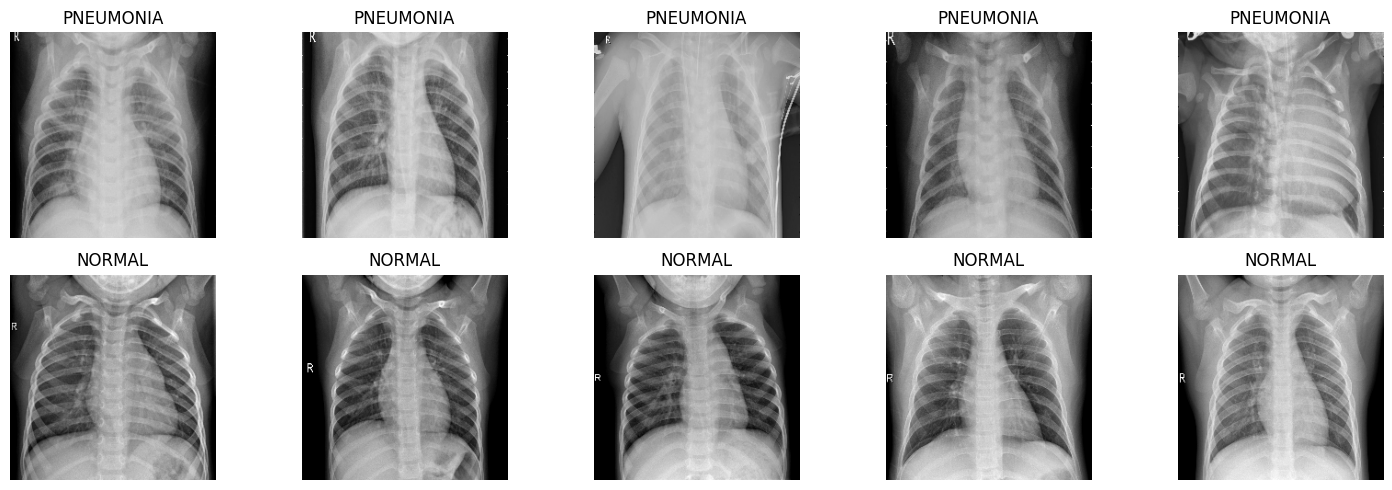

In [10]:
show_samples(train, labels, ["PNEUMONIA", "NORMAL"], samples_per_class=5)

In [11]:
print(os.listdir("/content/XRay_Data/chest_xray/train"))

['PNEUMONIA', 'NORMAL']


In [12]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_filenames = [f for f in os.listdir(path) if f.lower().endswith(valid_extensions)]

    # Limit the number of images to visualize
    num_images = min(num_images, len(image_filenames))

    if num_images == 0:
        print("No valid image files found in the specified path.")
        return

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Handle case where num_images is 1
    if num_images == 1:
        axes = [axes]

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        try:
            # Load the image using Matplotlib
            image_path = os.path.join(path, image_filename)
            image = mpimg.imread(image_path)

            # Display the image
            axes[i].imshow(image)
            axes[i].axis('off')  # Turn off axis
            axes[i].set_title(image_filename)  # Set image filename as title
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

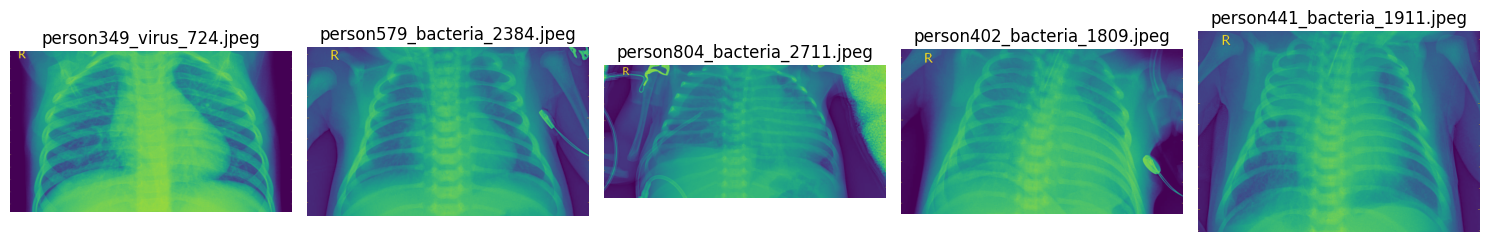

In [13]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/XRay_Data/chest_xray/train/PNEUMONIA"  # Point directly to PNEUMONIA folder

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

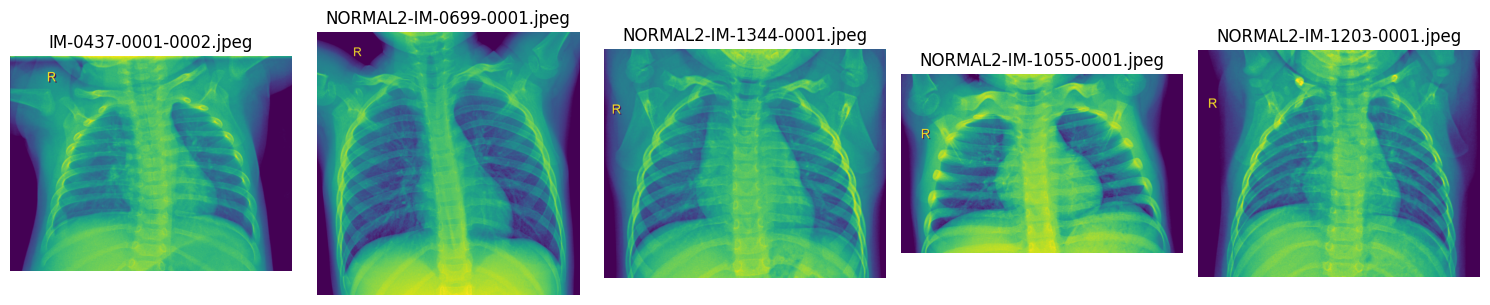

In [14]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/XRay_Data/chest_xray/train/NORMAL"
# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [15]:
list_of_data = []
for i in train:
  if(i[1]== 0 ):
    list_of_data.append("PNEUMONIA")
  else:
    list_of_data.append("NORMAL")

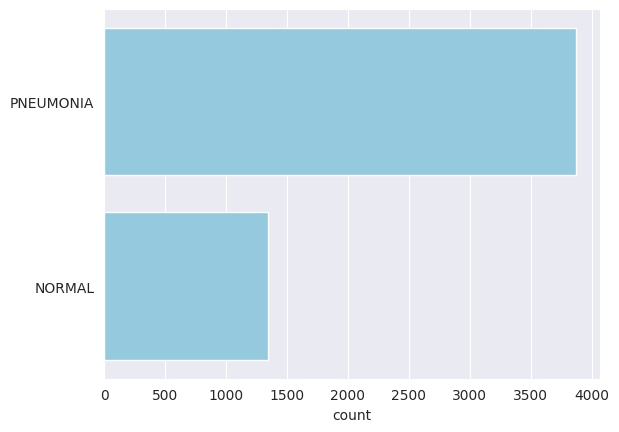

In [16]:
sns.set_style('darkgrid')
sns.countplot(list_of_data, color='skyblue')
plt.show()

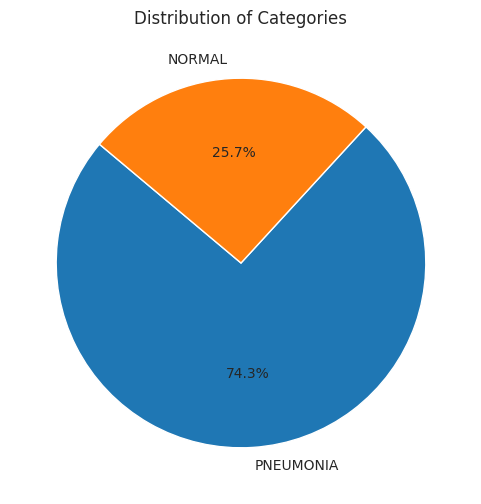

In [17]:
label_counts = Counter(list_of_data)
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts.values(),
    labels=label_counts.keys(),
    autopct='%1.1f%%',
    startangle=140,
)

plt.title('Distribution of Categories')
plt.show()

# **Data Augmentation and Resizing**

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,  # Increased from 20
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(
    "/content/XRay_Data/chest_xray/train",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    "/content/XRay_Data/chest_xray/val",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=True,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    "/content/XRay_Data/chest_xray/test",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False,  # Critical for correct evaluation
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [21]:
from tensorflow.keras.applications import MobileNetV2

# === Build Model ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
model_path = "best_model.h5"

# === Callbacks ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

In [25]:
import gc

# === Clean Memory ===
gc.collect()
tf.keras.backend.clear_session()

In [27]:

# === Train Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7591 - loss: 0.4968

163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 648ms/step - accuracy: 0.7595 - loss: 0.4960 - val_accuracy: 0.6875 - val_loss: 0.4408
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9047 - loss: 0.2362

163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 611ms/step - accuracy: 0.9047 - loss: 0.2361 - val_accuracy: 0.7500 - val_loss: 0.3828
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 619ms/step - accuracy: 0.9167 - loss: 0.2050 - val_accuracy: 0.7500 - val_loss: 0.3968
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9065 - loss: 0.2103

163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 622ms/step - accuracy: 0.9066 - loss: 0.2102 - val_accuracy: 0.7500 - val_loss: 0.3748
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 617ms/step - accuracy: 0.9330 - loss: 0.1760 - val_accuracy: 0.7500 - val_loss: 0.4325
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 616ms/step - accuracy: 0.9308 - loss: 0.1769 - val_accuracy: 0.7500 - val_loss: 0.3970
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9283 - loss: 0.1719 - val_accuracy: 0.8125 - val_loss: 0.3789
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 619ms/step - accuracy: 0.9325 - loss: 0.1655 - val_accuracy: 0.8125 - val_loss: 0.3890
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 611ms/step - accuracy: 0.9262 - loss: 0.1618 - val_accuracy: 0.8750 - val_loss: 0.3964


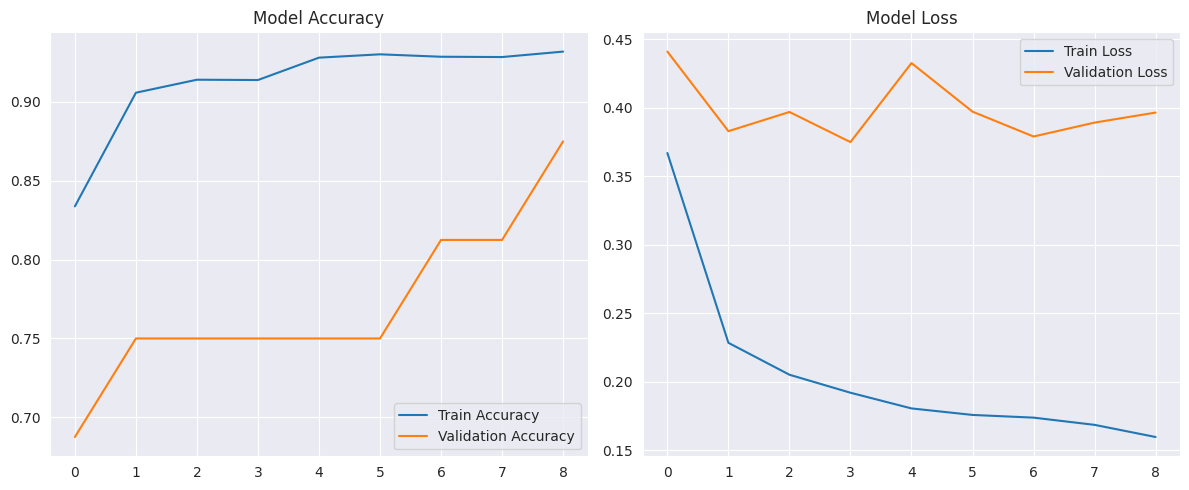

In [28]:

# === Plot Training Curves ===
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()

🧪 Evaluating on Test Data...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.8220 - loss: 0.3949
✅ Test Accuracy: 0.87
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step

📄 Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.75      0.81       234
   Pneumonia       0.86      0.94      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.84      0.85       624
weighted avg       0.87      0.87      0.87       624



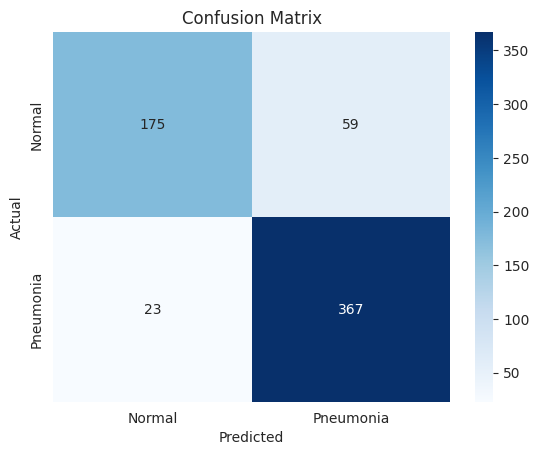

In [30]:

# === Evaluate on Test Data ===
print("🧪 Evaluating on Test Data...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc:.2f}")

# === Classification Report & Confusion Matrix ===
y_pred = model.predict(test_generator)
y_pred_class = (y_pred > 0.5).astype("int32").flatten()
y_true = test_generator.classes

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=["Normal", "Pneumonia"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess image
img = image.load_img("/content/Normal xray.jpeg", target_size=(image_size, image_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
prediction = model.predict(img_array)
predicted_class = int(prediction[0][0] > 0.5)  # binary classification
class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}
print("Predicted Class:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Class: NORMAL
